<a href="https://colab.research.google.com/github/rmogi/HousePrice/blob/branch-mogi/mogi/HousePrices_lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip house-prices-advanced-regression-techniques

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#データの読み込み
train = pd.read_csv("train.csv")
test_x = pd.read_csv("test.csv")

#学習データの変数を確認
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
# トレーニングデータの確認
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# テストデータの確認
test_x.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
print("shape train: %s, test: %s" % (train.shape, test_x.shape))

shape train: (1460, 81), test: (1459, 80)


In [7]:
#目的変数である家の価格の要約統計量を表示する
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

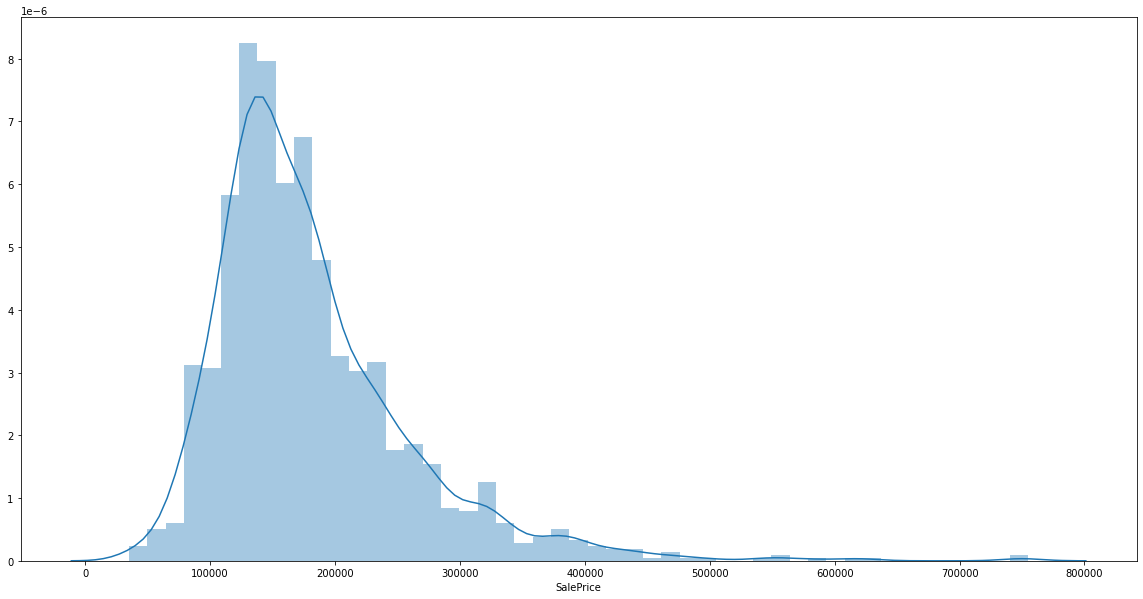

In [8]:
#目的変数である家の価格のヒストグラムを表示する
plt.figure(figsize=(20, 10), facecolor='w')
sns.distplot(train['SalePrice'])

In [9]:
#歪度と尖度を計算
print("歪度: %f" % train['SalePrice'].skew())
print("尖度: %f" % train['SalePrice'].kurt())

歪度: 1.882876
尖度: 6.536282


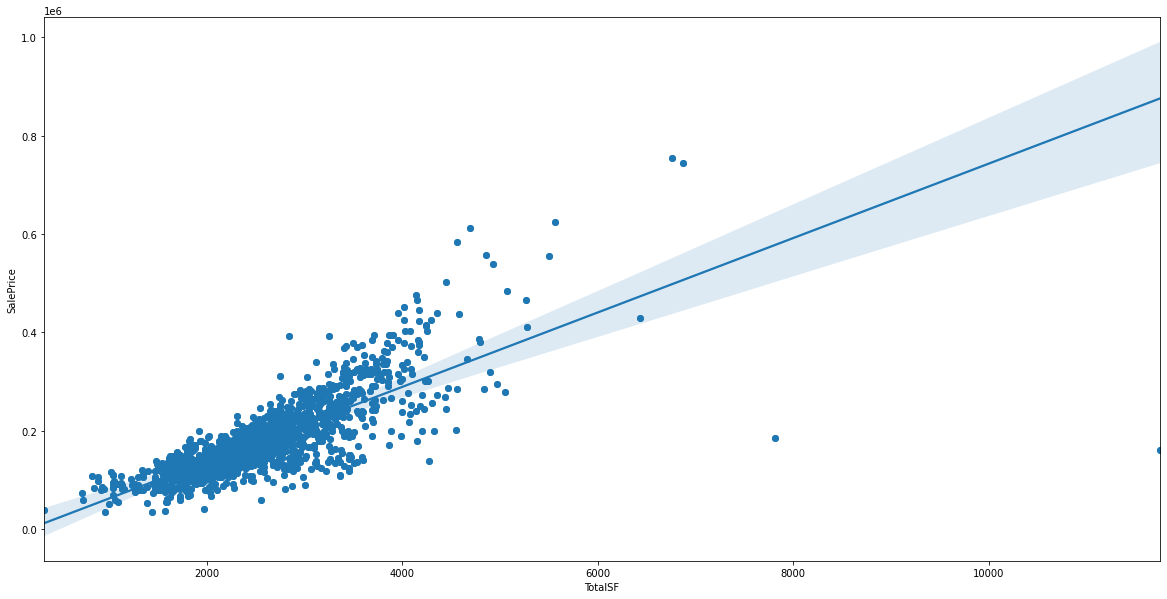

In [10]:
"""
1stFlrSF: 1階の広さ
2ndFlrSF: 2階の広さ
TotalBsmtSF: 地下の広さ
"""
#物件の広さを合計した変数を作成
train["TotalSF"] = train["1stFlrSF"] + train["2ndFlrSF"] + train["TotalBsmtSF"]
test_x["TotalSF"] = test_x["1stFlrSF"] + test_x["2ndFlrSF"] + test_x["TotalBsmtSF"]

#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(20, 10), facecolor="w")
plt.scatter(train["TotalSF"],train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")
sns.regplot(x=train.TotalSF, y=train.SalePrice)

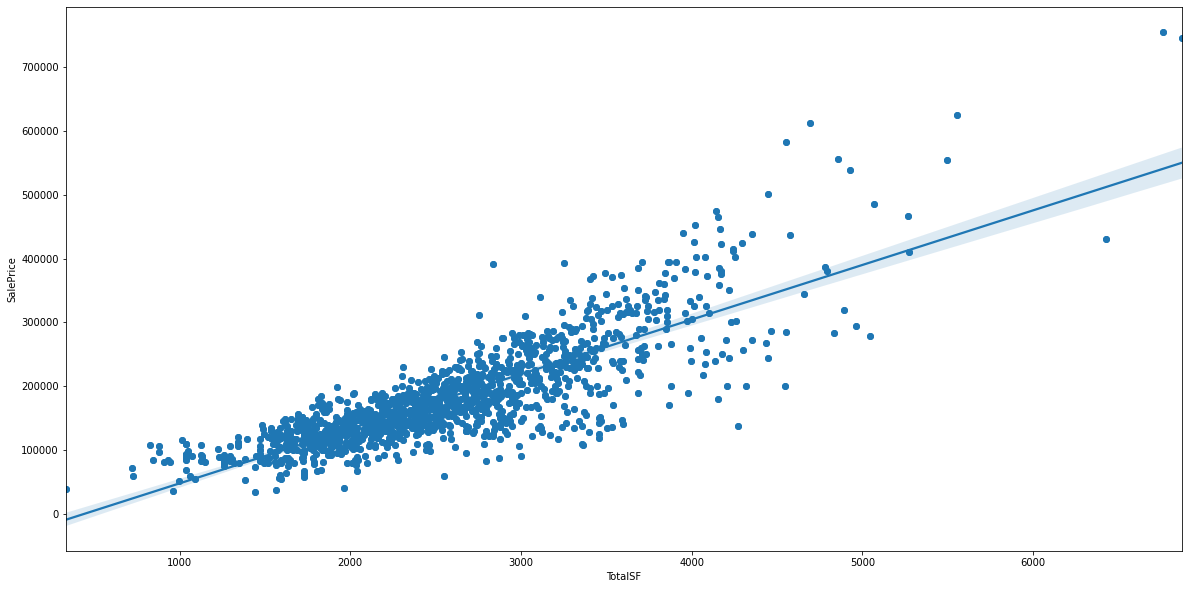

In [11]:
#外れ値を除外する
train = train.drop(train[(train['TotalSF']>7500) & (train['SalePrice']<300000)].index)

#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(20, 10), facecolor="w")
plt.scatter(train["TotalSF"],train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")
sns.regplot(x=train.TotalSF, y=train.SalePrice)

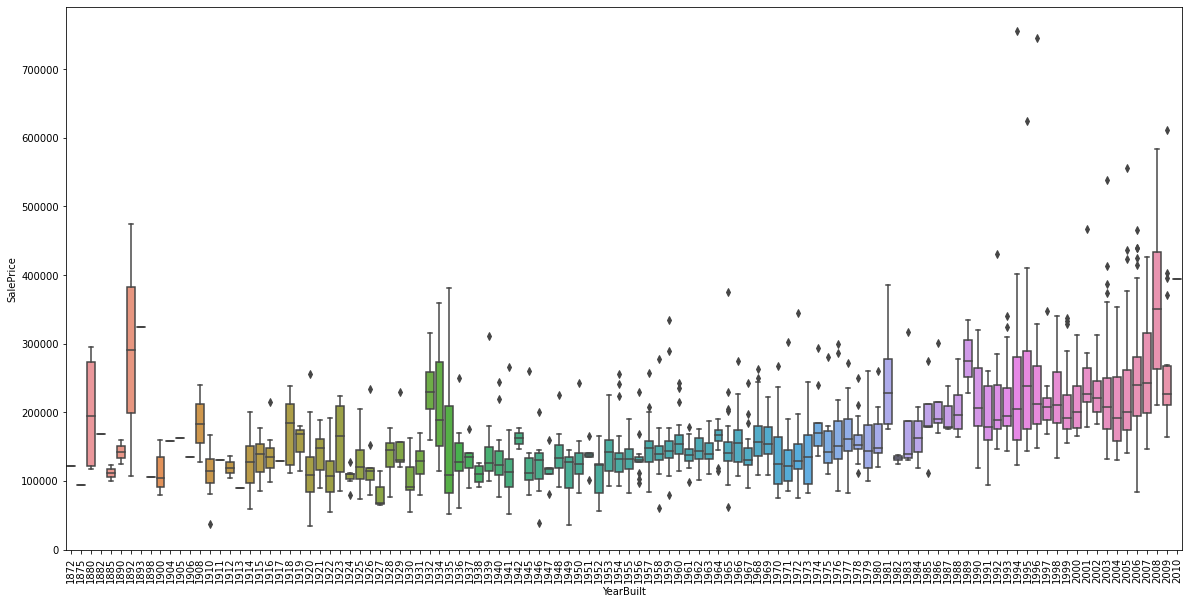

In [12]:
#築年数と物件価格の散布図を作成
data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10), facecolor="w")
plt.xticks(rotation='90')
sns.boxplot(x="YearBuilt",y="SalePrice",data=data)

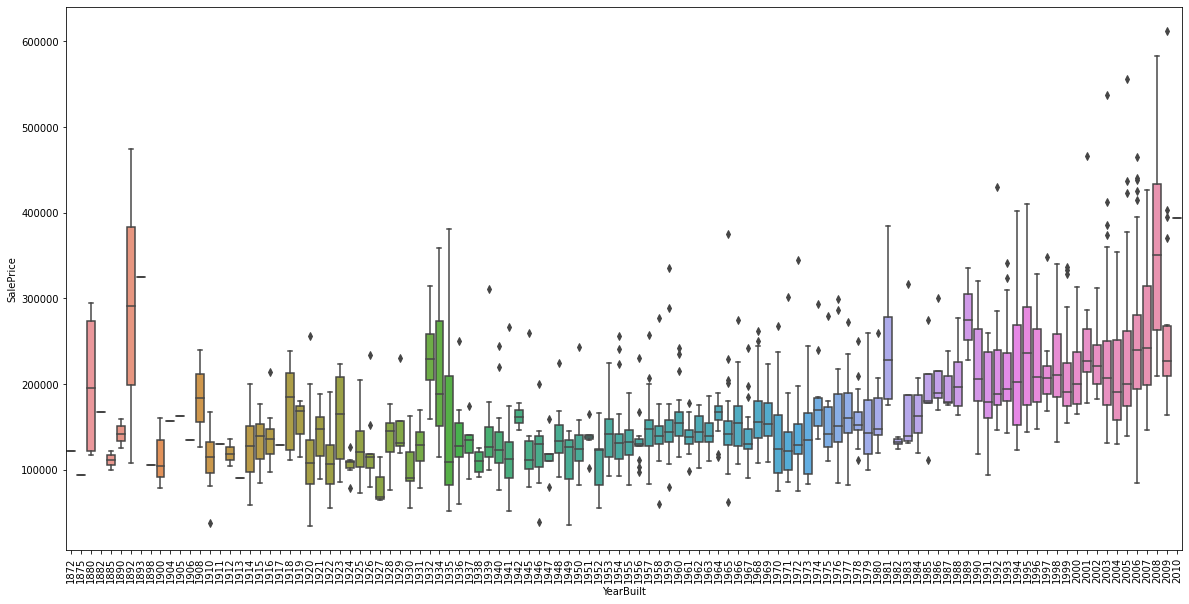

In [13]:
#外れ値を除外する
train = train.drop(train[(train['YearBuilt']<2000) & (train['SalePrice']>600000)].index)

#グラフを描画する
data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10), facecolor="w")
plt.xticks(rotation='90')
sns.boxplot(x="YearBuilt",y="SalePrice",data=data)

Text(0, 0.5, 'SalePrice')

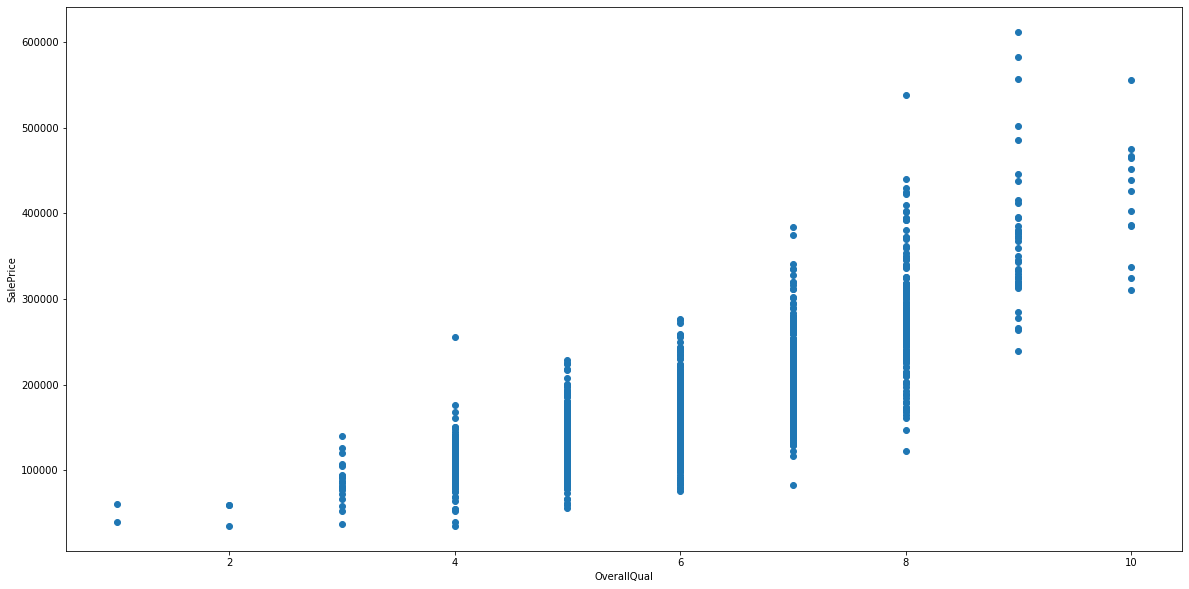

In [14]:
#家の材質・完成度と物件価格の散布図を作成
plt.figure(figsize=(20, 10), facecolor="w")
plt.scatter(train["OverallQual"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

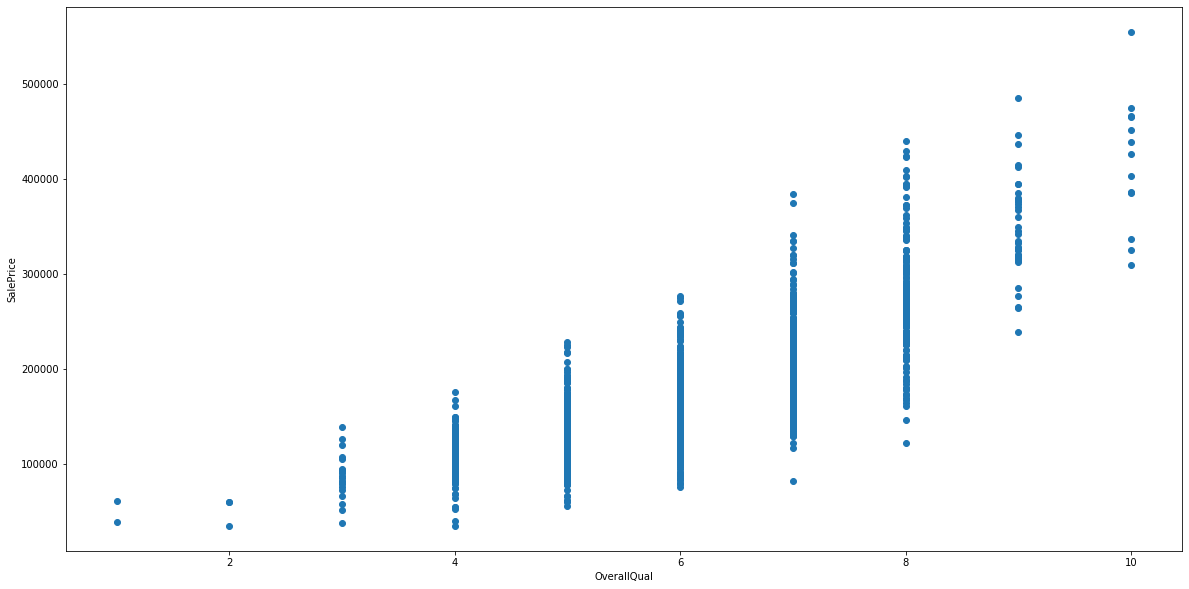

In [15]:
#外れ値を除外する
train = train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index)
train = train.drop(train[(train['OverallQual']<10) & (train['SalePrice']>500000)].index)

#グラフを描画する
plt.figure(figsize=(20, 10), facecolor="w")
plt.scatter(train["OverallQual"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

In [16]:
#学習データを目的変数とそれ以外に分ける
train_x = train.drop("SalePrice",axis=1)
train_y = train["SalePrice"]

#学習データとテストデータを統合
all_data = pd.concat([train_x,test_x],axis=0,sort=True)

#IDのカラムは不必要なので別の変数に格納
train_ID = train['Id']
test_ID = test_x['Id']

all_data.drop("Id", axis = 1, inplace = True)

#それぞれのデータのサイズを確認
print("train_x: "+str(train_x.shape))
print("train_y: "+str(train_y.shape))
print("test_x: "+str(test_x.shape))
print("all_data: "+str(all_data.shape))

train_x: (1449, 81)
train_y: (1449,)
test_x: (1459, 81)
all_data: (2908, 80)


In [17]:
#データの欠損値を確認する
all_data_na = all_data.isnull().sum()[all_data.isnull().sum()>0].sort_values(ascending=False)
all_data_na

PoolQC          2900
MiscFeature     2803
Alley           2710
Fence           2338
FireplaceQu     1420
LotFrontage      485
GarageCond       159
GarageFinish     159
GarageQual       159
GarageYrBlt      159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior1st        1
Electrical         1
BsmtUnfSF          1
Exterior2nd        1
TotalSF            1
GarageCars         1
KitchenQual        1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
TotalBsmtSF        1
GarageArea         1
dtype: int64

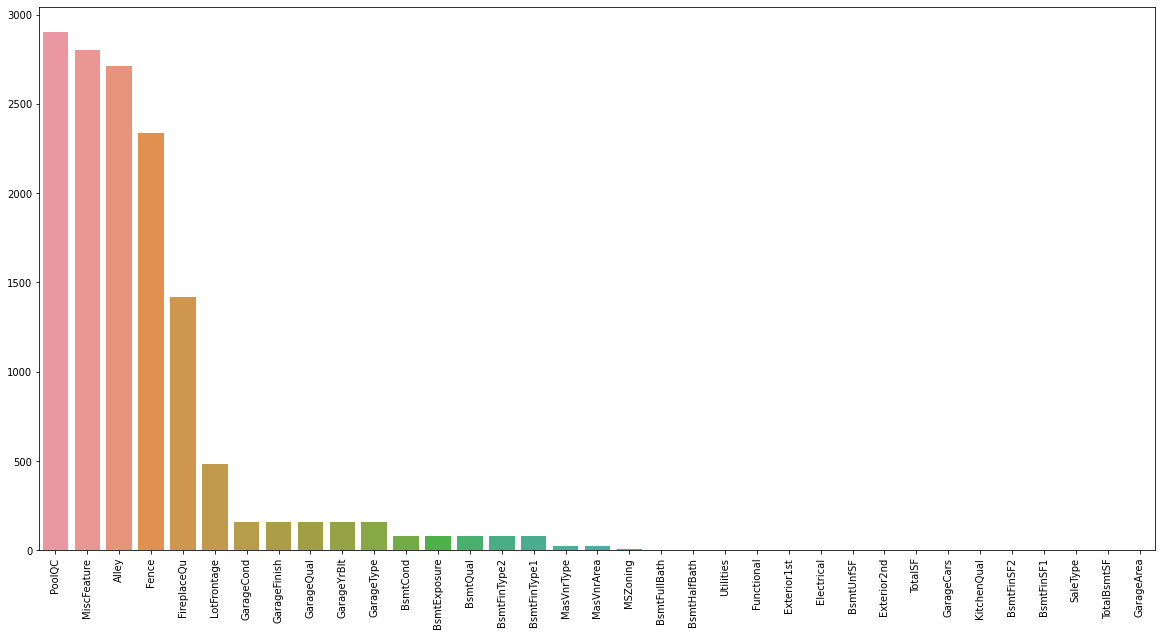

In [18]:
#欠損値の数をグラフ化
plt.figure(figsize=(20,10), facecolor="w")
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)

In [19]:
# 欠損値があるカラムをリスト化
na_col_list = all_data.isnull().sum()[all_data.isnull().sum()>0].index.tolist()

#欠損があるカラムのデータ型を確認
all_data[na_col_list].dtypes.sort_values()

GarageArea      float64
TotalBsmtSF     float64
TotalSF         float64
BsmtFinSF1      float64
BsmtFinSF2      float64
GarageYrBlt     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageCars      float64
BsmtUnfSF       float64
MasVnrArea      float64
LotFrontage     float64
GarageType       object
KitchenQual      object
MasVnrType       object
MiscFeature      object
PoolQC           object
SaleType         object
MSZoning         object
GarageQual       object
Alley            object
GarageCond       object
Functional       object
FireplaceQu      object
Fence            object
Exterior2nd      object
Exterior1st      object
Electrical       object
BsmtQual         object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
GarageFinish     object
Utilities        object
dtype: object

In [20]:
#隣接した道路の長さ（LotFrontage）の欠損値の補完
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#欠損値が存在するかつfloat型のリストを作成
float_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "float64"].index.tolist()

#欠損値が存在するかつobject型のリストを作成
obj_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "object"].index.tolist()

#float型の場合は欠損値を0で置換
all_data[float_list] = all_data[float_list].fillna(0)

#object型の場合は欠損値を"None"で置換
all_data[obj_list] = all_data[obj_list].fillna("None")

#欠損値が全て置換できているか確認
all_data.isnull().sum()[all_data.isnull().sum() > 0]

Series([], dtype: int64)

In [21]:
# カテゴリ変数に変換する
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

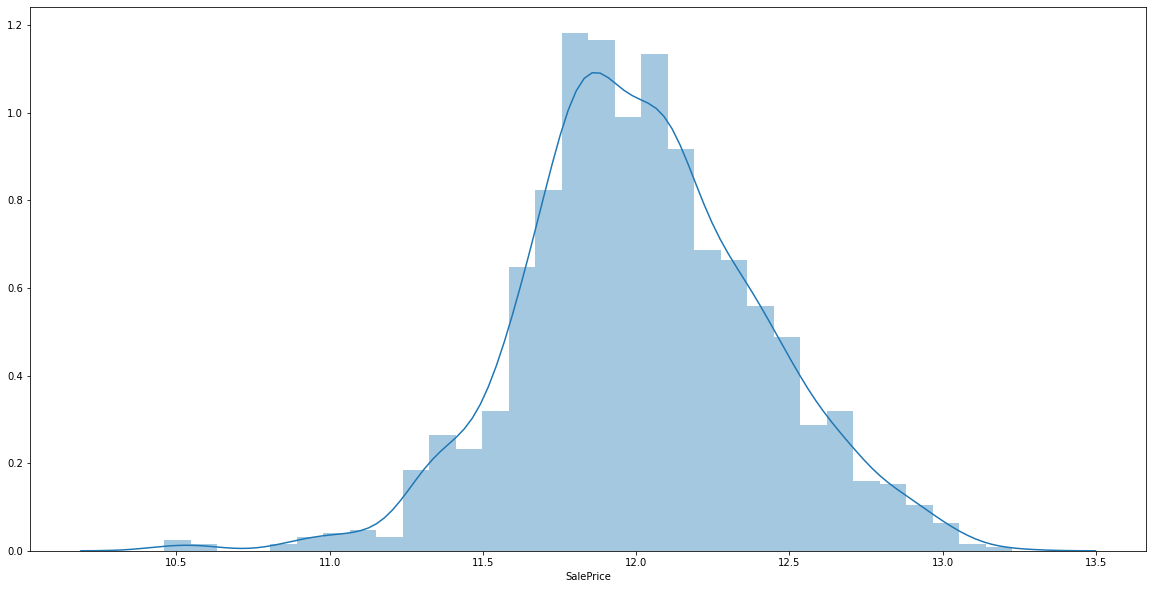

In [22]:
#目的変数の対数log(x+1)をとる
train_y = np.log1p(train_y)

#分布を可視化
plt.figure(figsize=(20, 10), facecolor='w')
sns.distplot(train_y)

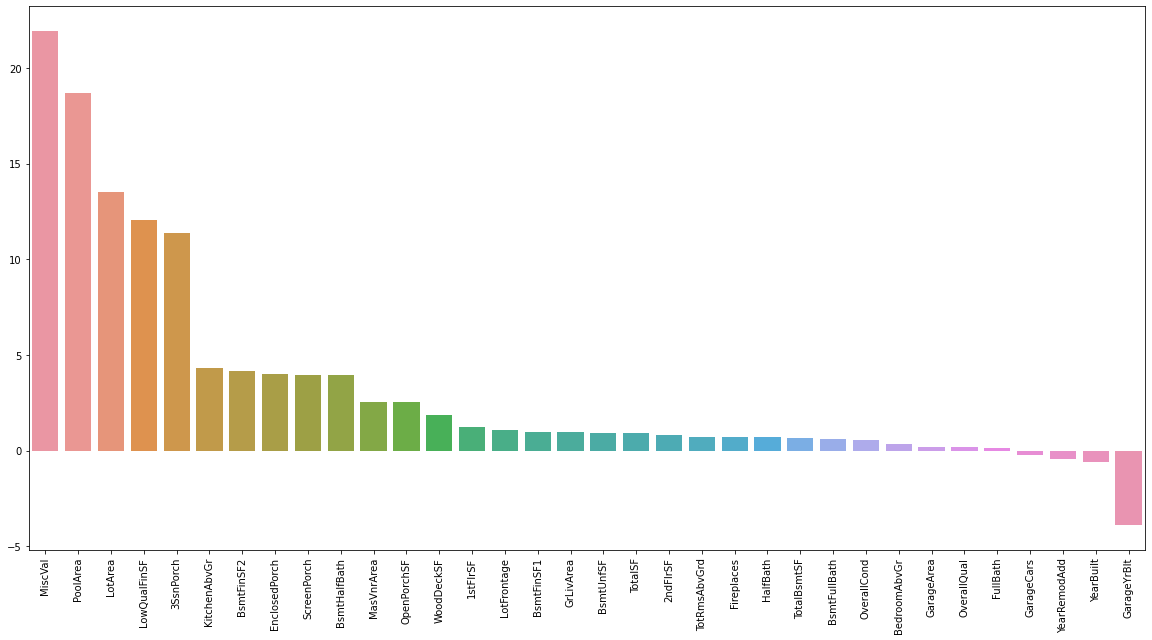

In [23]:
#数値の説明変数のリストを作成
num_feats = all_data.dtypes[all_data.dtypes != "object" ].index

#各説明変数の歪度を計算
skewed_feats = all_data[num_feats].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10), facecolor="w")
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats.index, y=skewed_feats)

In [24]:
#歪度の絶対値が0.5より大きい変数だけに絞る
skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5].index

#各変数の最小値を表示
for i in skewed_feats_over:
    print(min(all_data[i]))

0
0
1300
0
0
0
0.0
0
0
0.0
0.0
0
0
334
21.0
0.0
334
0.0
0.0
0
2
0
0
0.0
0.0
1
1872
0.0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


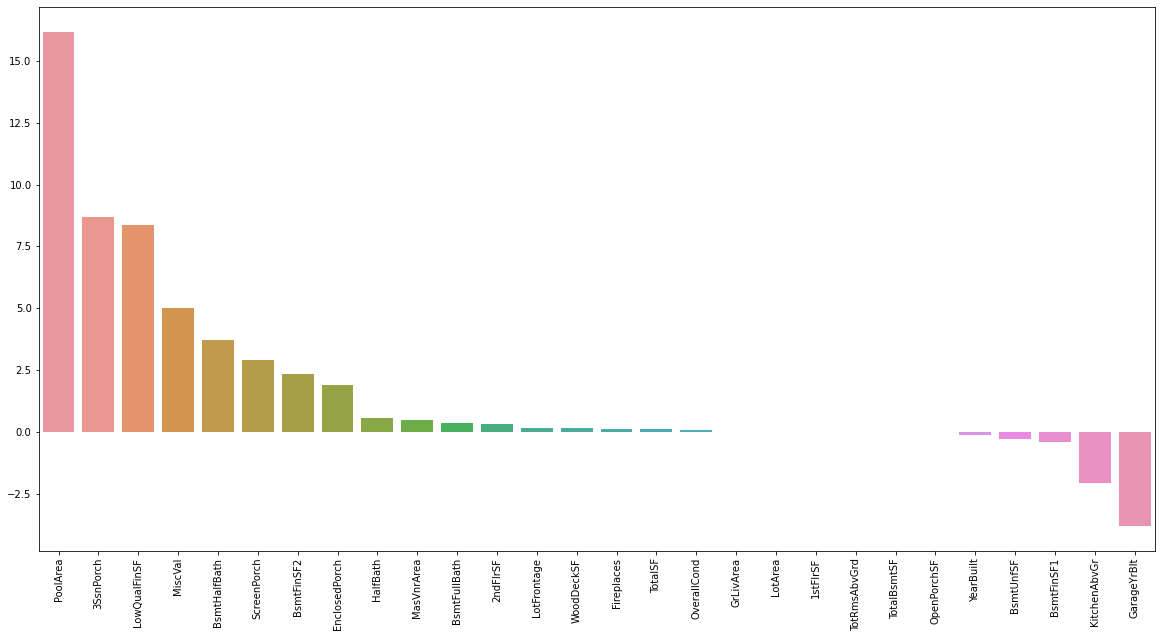

In [25]:
#Yeo-Johnson変換
pt = PowerTransformer()
pt.fit(all_data[skewed_feats_over])

#変換後のデータで各列を置換
all_data[skewed_feats_over] = pt.transform(all_data[skewed_feats_over])

#各説明変数の歪度を計算
skewed_feats_fixed = all_data[skewed_feats_over].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10), facecolor="w")
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats_fixed.index, y=skewed_feats_fixed)

In [26]:
#特徴量に1部屋あたりの面積を追加
all_data["FeetPerRoom"] =  all_data["TotalSF"]/all_data["TotRmsAbvGrd"]

#その他有効そうなものを追加する

#建築した年とリフォームした年の合計
all_data['YearBuiltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

#バスルームの合計面積
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

#縁側の合計面積
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

#プールの有無
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

#2階の有無
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

#ガレージの有無
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

#地下室の有無
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

#暖炉の有無
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [27]:
#各カラムのデータ型を確認
all_data.dtypes.value_counts()

object     46
float64    34
int64       9
dtype: int64

In [28]:
#カテゴリ変数となっているカラムを取り出す
cal_list = all_data.dtypes[all_data.dtypes=="object"].index.tolist()

#学習データにおけるカテゴリ変数のデータ数を確認
train_x[cal_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1459
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Alley          91 non-null     object
 1   BldgType       1449 non-null   object
 2   BsmtCond       1412 non-null   object
 3   BsmtExposure   1411 non-null   object
 4   BsmtFinType1   1412 non-null   object
 5   BsmtFinType2   1411 non-null   object
 6   BsmtQual       1412 non-null   object
 7   CentralAir     1449 non-null   object
 8   Condition1     1449 non-null   object
 9   Condition2     1449 non-null   object
 10  Electrical     1448 non-null   object
 11  ExterCond      1449 non-null   object
 12  ExterQual      1449 non-null   object
 13  Exterior1st    1449 non-null   object
 14  Exterior2nd    1449 non-null   object
 15  Fence          280 non-null    object
 16  FireplaceQu    759 non-null    object
 17  Foundation     1449 non-null   object
 18  Functional     1449 non-null

In [29]:
all_data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [34]:
#カテゴリ変数をget_dummiesによるone-hot-encodingを行う
dummies = ['BldgType', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
           'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'GarageType',
           'Heating', 'HouseStyle', 'LandContour','LandSlope', 'LotConfig','MSZoning',
           'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'PavedDrive', 'RoofMatl',
           'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities', 'YrSold']

all_data = pd.get_dummies(all_data,columns=dummies)

from sklearn.preprocessing import LabelEncoder

col = ('MSSubClass', 'LotShape', 'OverallQual', 'OverallCond', 
       'ExterQual', 'ExterCond', 'BsmtCond', 'HeatingQC', 'BsmtFinType1', 
       'BsmtFinType2', 'BsmtExposure', 'KitchenQual', 'Functional', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Alley')

# 列を処理し、LabelEncoderをカテゴリカル機能に適用する
for c in col:
  le = LabelEncoder()
  le.fit(list(all_data[c].values))
  all_data[c] = le.transform(list(all_data[c].values))

#サイズを確認
all_data.shape

(2908, 271)

In [35]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,ExterCond,ExterQual,Fireplaces,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LotArea,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,OpenPorchSF,OverallCond,...,PavedDrive_Y,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,Utilities_None,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,0.0,1.186431,-0.113523,1,3,4,3,0.809676,-0.368092,2,6,1.171560,-0.252276,-0.868779,-0.432921,4,2,-0.999982,2,7,548.0,2.0,5,2,5,0.368670,0.575738,1.296997,0,-0.166282,2,0.0,-0.153645,3,-0.118097,10,1.257462,-0.191625,0.832156,4,...,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0
1,0.0,-0.863087,-0.113523,1,3,4,1,1.023186,-0.368092,0,6,-0.839209,3.963918,-0.415562,-0.432921,4,3,0.829077,2,7,460.0,2.0,5,2,5,0.226723,-0.373403,-0.766061,0,-0.166282,4,0.0,0.547327,3,-0.118097,5,-0.802757,-0.191625,-1.077144,7,...,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0
2,0.0,1.189002,-0.113523,1,3,4,2,0.583704,-0.368092,2,6,1.171560,-0.252276,-0.029832,-0.432921,4,2,0.829077,2,7,608.0,2.0,5,2,5,0.358065,0.712963,1.296997,0,-0.166282,2,0.0,-0.009187,0,-0.118097,10,1.222841,-0.191625,0.657146,4,...,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0
3,0.0,1.163764,-0.113523,1,3,1,3,0.154447,-0.368092,0,6,1.171560,-0.252276,0.201027,2.315916,4,3,0.829077,1,7,642.0,3.0,5,3,5,0.342185,0.588615,-0.766061,2,-0.166282,2,0.0,-0.399804,0,-0.118097,11,-0.802757,-0.191625,0.572579,4,...,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0
4,0.0,1.224520,-0.113523,1,4,4,0,0.762749,-0.368092,2,6,1.171560,-0.252276,0.095451,-0.432921,4,2,0.829077,2,7,836.0,3.0,5,2,5,0.352768,1.372736,1.296997,0,-0.166282,2,0.0,0.726074,0,-0.118097,10,1.352864,-0.191625,0.983971,4,...,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0


In [36]:
#学習データとテストデータに再分割
train_x = all_data.iloc[:train_x.shape[0],:].reset_index(drop=True)
test_x = all_data.iloc[train_x.shape[0]:,:].reset_index(drop=True)

#サイズを確認
print("train_x: "+str(train_x.shape))
print("test_x: "+str(test_x.shape))

train_x: (1449, 271)
test_x: (1459, 271)


In [37]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [38]:
# データの分割
train_x, valid_x, train_y, valid_y = train_test_split(
        train_x,
        train_y,
        test_size=0.3,
        random_state=0)

In [39]:
#特徴量と目的変数をxgboostのデータ構造に変換する
train_data = lgb.Dataset(train_x, label=train_y)
eval_data = lgb.Dataset(valid_x, label=valid_y, reference=train_data)

In [40]:
#パラメータを指定してGBDT
num_boost_round = 5000
evallist = [(eval_data, 'eval'), (train_data, 'train')]

evals_result = {}

In [41]:
#パラメータ
param = {
    'max_depth': 3,
    'eta': 0.01,
    'objective': 'root_mean_squared_error',
}

In [42]:
#学習の実行
gbm = lgb.train(
    param, train_data,
    valid_sets=eval_data,
    num_boost_round=5000,
    #evallist,
    evals_result=evals_result,
    early_stopping_rounds=1000
    )

[1]	valid_0's rmse: 0.381765
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's rmse: 0.378722
[3]	valid_0's rmse: 0.375728
[4]	valid_0's rmse: 0.372758
[5]	valid_0's rmse: 0.369837
[6]	valid_0's rmse: 0.366934
[7]	valid_0's rmse: 0.364108
[8]	valid_0's rmse: 0.361321
[9]	valid_0's rmse: 0.358552
[10]	valid_0's rmse: 0.3558
[11]	valid_0's rmse: 0.353078
[12]	valid_0's rmse: 0.350425
[13]	valid_0's rmse: 0.347761
[14]	valid_0's rmse: 0.34514
[15]	valid_0's rmse: 0.342603
[16]	valid_0's rmse: 0.340043
[17]	valid_0's rmse: 0.337565
[18]	valid_0's rmse: 0.335036
[19]	valid_0's rmse: 0.332606
[20]	valid_0's rmse: 0.330214
[21]	valid_0's rmse: 0.327764
[22]	valid_0's rmse: 0.325422
[23]	valid_0's rmse: 0.323066
[24]	valid_0's rmse: 0.320779
[25]	valid_0's rmse: 0.318435
[26]	valid_0's rmse: 0.316232
[27]	valid_0's rmse: 0.31398
[28]	valid_0's rmse: 0.311803
[29]	valid_0's rmse: 0.309569
[30]	valid_0's rmse: 0.307372
[31]	valid_0's rmse: 0.305195
[32]	valid_0's rmse

In [43]:
test_X = np.exp(gbm.predict(test_x))
test_X

array([122679.12737432, 164104.22473913, 187195.59974165, ...,
       149446.4443664 , 125483.3812748 , 223973.90343185])

In [44]:
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": test_X
})
submission.to_csv('LGB.csv', index=False)